## Table of contents


1. Install the TensorFlow Object detection API
2. Select the model for training
3. Image, Label, Annotation, Training vs Testing data
4. Process images & labels
5. Download Tensorflow model which contains Object Detection API
6. Generate Tensorflow record
7. Download the Base Model which was selected above and is used for training
8. Configure the Training Pipeline
9. Create Tensorboard link for monitoring the training process
10. Begin to train model
11. Export the trained model for reuse - inference
12. Test video


## Install the TensorFlow Object detection API

Map google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
#!cp "/content/rider_detection" -r "/gdrive/My Drive/Classroom/VRA/"
#!rm -rf "/content/drive/My Drive/Classroom/VRA/rider_detection (1)"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Go to project main directory
%cd '/content/gdrive/My Drive/Classroom/VRA/walking'

/content/gdrive/My Drive/Classroom/VRA/walking


Install tensorflow with version 1.15.0

In [ ]:
# we need tenorflow v 1.15.0, object detection API is removed from tf v 2.0+
#! pip install torch==1.4.0+cpu torchvision==0.5.0+cpu -f https://download.pytorch.org/whl/torch_stable.html
!pip install gast==0.2.2
!pip install -U --pre tensorflow=="1.15.0"
!pip install tf_slim

Requirement already up-to-date: tensorflow==1.15.0 in /usr/local/lib/python3.6/dist-packages (1.15.0)


Install protobuf

In [ ]:
# Protocol Buffers (Protobuf) is a method of serializing structured data. 
# It is useful in developing programs to communicate with each other over a network or for storing data.

!apt-get update && apt-get install alien

# The Tensorflow Object Detection API uses Protobufs to configure model and training parameters. 
# Before the framework can be used, the Protobuf libraries must be compiled. 
# This should be done by running the following command from the models/research/ directory
!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk

!pip install -qq Cython contextlib2 pillow lxml matplotlib

# COCO is a large image dataset designed for object detection, segmentation, person keypoints detection, stuff segmentation, and caption generation. 
# COCO API package provides Python APIs that assists in loading, parsing, and visualizing the annotations in COCO, and will be present in your system as pycocotools
!pip install -qq pycocotools

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Reading package lists... Done
Reading package lists... Done
B

Import all necessary classes

In [ ]:
from __future__ import division, print_function, absolute_import

import pandas as pd
import numpy as np
import csv
import re
import cv2 
import os
import glob
import xml.etree.ElementTree as ET

import io
import tensorflow.compat.v1 as tf

from PIL import Image
from collections import namedtuple, OrderedDict

import shutil
import urllib.request
import tarfile

from google.colab import files

!pip install lvis

Check Tensor Flow version

In [ ]:
print(tf.__version__)

1.15.0


## Select the model for training

In [ ]:
# There are many models to be selected
# https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf1_detection_zoo.md

# ssd_mobilenet_v2: the quickest and least accuracy
# faster_rcnn_inception_v2: the best accuracy but worst in bounding rectangles
# rfcn_resnet101 is comparable to faster_rcnn_inception_v2 but a bit behind

MODELS_CONFIG = {
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
        'pipeline_file': 'ssd_mobilenet_v2_coco.config',
    },
    'faster_rcnn_inception_v2': {
        'model_name': 'faster_rcnn_inception_v2_coco_2018_01_28',
        'pipeline_file': 'faster_rcnn_inception_v2_pets.config',
    },
    'rfcn_resnet101': {
        'model_name': 'rfcn_resnet101_coco_2018_01_28',
        'pipeline_file': 'rfcn_resnet101_pets.config',
    }
}

# selected model
selected_model = 'faster_rcnn_inception_v2' #'ssd_mobilenet_v2'


## Image, Label, Annotation, Training vs Testing data

In [ ]:
# Create a directory to contain all training & testing data
# Images: all the image used for training & testing model
# *_Labels: xml files with bounding boxes of object area, processed by LabelImg
# train_labels: at first, all xml is inputed here
# Video: outcome of final model
!mkdir data
!mkdir data/images data/train_labels data/test_labels data/video

mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘data/images’: File exists
mkdir: cannot create directory ‘data/train_labels’: File exists
mkdir: cannot create directory ‘data/test_labels’: File exists


In [ ]:
# Mix all labels in a random order (not really random, by their hash value instead)
# Moves 20% labels to the testing directory test_labels
!ls data/train_labels/* | sort -R | head -310 | xargs -I{} mv {} data/test_labels

In [ ]:
# Count training data
!ls -1 data/train_labels/ | wc -l

1232


In [ ]:
# Count testing data
!ls -1 data/test_labels/ | wc -l

310


## Process images & labels
1. Converting the annotations from xml files to two csv files for each `train_labels/` and `train_labels/`.
2. Creating a pbtxt file that specifies the number of class (one class in this case)
3. Checking if the annotations for each object are placed within the range of the image width and height.

In [ ]:
# Go to data directory
%cd /content/gdrive/My Drive/Classroom/VRA/Walking_RCNN/data


# Select images extension
images_extension = 'jpg'

# Create a function to convert label to csv
## label: xml files extracted by LabelImg
## csv: contain value of image name, width, height, class, xmin, ymin, xmax, ymax
# If an image has more than 1 class, then 1 xml will turn into multiple rows in which 1 row contains info of 1 rectangle box

def xml_to_csv(path):
  classes_names = []
  xml_list = []

  for xml_file in glob.glob(path + '/*.xml'):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    for member in root.findall('object'):
      classes_names.append(member[0].text)
      value = (root.find('filename').text,# + '.' + images_extension,
               int(root.find('size')[0].text),
               int(root.find('size')[1].text),
               member[0].text,
               int(member[4][0].text),
               int(member[4][1].text),
               int(member[4][2].text),
               int(member[4][3].text))
      xml_list.append(value)
  column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
  xml_df = pd.DataFrame(xml_list, columns=column_name) 
  classes_names = list(set(classes_names))
  classes_names.sort()
  return xml_df, classes_names

# for both the train_labels and test_labels csv files, it runs the xml_to_csv() above.
for label_path in ['train_labels', 'test_labels']:
  image_path = os.path.join(os.getcwd(), label_path)
  xml_df, classes = xml_to_csv(label_path)
  xml_df.to_csv(f'{label_path}.csv', index=None)
  print(f'Successfully converted {label_path} xml to csv.')

# Create pbtxt file which contains graph information of all labels in each of image_path
label_map_path = os.path.join("label_map.pbtxt")

pbtxt_content = ""

#creats a pbtxt file the has the class names.
for i, class_name in enumerate(classes):
    # display_name is optional.
    pbtxt_content = (
        pbtxt_content
        + "item {{\n    id: {0}\n    name: '{1}'\n    display_name: '{1}'\n }}\n\n".format(i + 1, class_name)
    )
pbtxt_content = pbtxt_content.strip()
with open(label_map_path, "w") as f:
    f.write(pbtxt_content)


/content/gdrive/My Drive/Classroom/VRA/walking/data
Successfully converted train_labels xml to csv.
Successfully converted test_labels xml to csv.


In [ ]:
#checking the pbtxt file
!cat label_map.pbtxt

item {
    id: 1
    name: 'bike_walker'
    display_name: 'bike_walker'
 }

item {
    id: 2
    name: 'motor_walker'
    display_name: 'motor_walker'
 }

In [ ]:
# check all files created: csv, pbtxt
!ls -l

total 101
drwx------ 2 root root  4096 Nov 22 13:04 images
-rw------- 1 root root   154 Jan  3 12:50 label_map.pbtxt
drwx------ 2 root root  4096 Nov 22 13:04 test_labels
-rw------- 1 root root 17220 Jan  3 12:50 test_labels.csv
drwx------ 2 root root  4096 Nov 22 13:04 train_labels
-rw------- 1 root root 68494 Jan  3 12:48 train_labels.csv
drwx------ 2 root root  4096 Nov 22 14:27 video


In [ ]:
# Check if there is any image without bounding box of object
# The non-bounding box image will raise error when running model
%cd '/content/gdrive/My Drive/Classroom/VRA/Walking_RCNN/data'
# path to images
images_path = 'images'

for CSV_FILE in ['train_labels.csv', 'test_labels.csv']:
  with open(CSV_FILE, 'r') as fid:  
      print('[*] Checking file:', CSV_FILE) 
      file = csv.reader(fid, delimiter=',')
      first = True 
      cnt = 0
      error_cnt = 0
      error = False
      for row in file:
          if error == True:
              error_cnt += 1
              error = False         
          if first == True:
              first = False
              continue     
          cnt += 1      
          name, width, height, xmin, ymin, xmax, ymax = row[0], int(row[1]), int(row[2]), int(row[4]), int(row[5]), int(row[6]), int(row[7])     
          path = os.path.join(images_path, name)
          img = cv2.imread(path)
          # Write error file with specified issue
          if type(img) == type(None):
              error = True
              print('Could not read image', img)
              continue     
          org_height, org_width = img.shape[:2]     
          if org_width != width:
              error = True
              print('Width mismatch for image: ', name, width, '!=', org_width)     
          if org_height != height:
              error = True
              print('Height mismatch for image: ', name, height, '!=', org_height) 
          if xmin > org_width:
              error = True
              print('XMIN > org_width for file', name)  
          if xmax > org_width:
              error = True
              print('XMAX > org_width for file', name)
          if ymin > org_height:
              error = True
              print('YMIN > org_height for file', name)
          if ymax > org_height:
              error = True
              print('YMAX > org_height for file', name)
          if error == True:
              print('Error for file: %s' % name)
              print()
      print()
      print('Checked %d files and realized %d errors' % (cnt, error_cnt))
      print("-----")

/content/gdrive/My Drive/Classroom/VRA/walking/data
[*] Checking file: train_labels.csv

Checked 1373 files and realized 0 errors
-----
[*] Checking file: test_labels.csv

Checked 345 files and realized 0 errors
-----


In [ ]:
# Remove the error image 
#rm images/'walk_1.jpg'

# Remove data in csv file

## In Training
# Read the training csv
df = pd.read_csv('/content/gdrive/My Drive/Classroom/VRA/Walking_RCNN/data/train_labels.csv')
# Remove walk_1.jpg
#df = df[df['filename'] != 'walk_1.jpg']
# Reset the index
#df.reset_index(drop=True, inplace=True)
# Save the df
df.to_csv('/content/gdrive/My Drive/Classroom/VRA/Walking_RCNN/data/train_labels.csv')


## In Testing
# Read the testing csv
df = pd.read_csv('/content/gdrive/My Drive/Classroom/VRA/Walking_RCNN/data/test_labels.csv')
# Remove walk_1.jpg
#df = df[df['filename'] != 'walk_1.jpg']
# Reset the index
#df.reset_index(drop=True, inplace=True)
# Save the df
df.to_csv('/content/gdrive/My Drive/Classroom/VRA/Walking_RCNN/data/test_labels.csv')

# Release memory
df = None


## Download Tensorflow model which contains Object Detection API
1. Clone [Tensorflow models](https://github.com/tensorflow/models.git) from the offical git repo
2. Compile the protos and adding folders to the os environment
* This protobuf file contains everything needed to reconstruct a tensorflow graph. You can load in the graph_protobuf. pbtxt to retrieve the program. Changing the internals of this file is analogous to programming a new graph program
3. Test the model builder

In [ ]:
# Download Tenorflow
%cd /content/gdrive/My Drive/Classroom/VRA/walking/
!git clone --q https://github.com/tensorflow/models.git

/content/gdrive/My Drive/Classroom/VRA/walking


In [ ]:
%cd /content/gdrive/My Drive/Classroom/VRA/walking/models/research
# Compile protocal buffers
!protoc object_detection/protos/*.proto --python_out=.

# Export the PYTHONPATH environment variable with the reasearch and slim folders' paths
os.environ['PYTHONPATH'] += ':/content/gdrive/My Drive/Classroom/VRA/walking/models/research/:/content/gdrive/My Drive/Classroom/VRA/walking/models/research/slim/'

/content/gdrive/My Drive/Classroom/VRA/walking/models/research


In [ ]:
%cd /content/gdrive/My Drive/Classroom/VRA/walking/models/research
# Test the model builder if there is any error
!python3 object_detection/builders/model_builder_test.py

/content/gdrive/My Drive/Classroom/VRA/walking/models/research


## Generate Tensorflow record
* Generate 2 training & testing CSVs to TFRecords files
* Tensorflow accepts the data as tfrecords which is a binary file that run fast with low memory usage. Instead of loading the full data into memory, Tenorflow breaks the data into batches using these TFRecords automatically

In [ ]:

from object_detection.utils import dataset_util
%cd '/content/gdrive/My Drive/Classroom/VRA/Walking_RCNN/models/'

DATA_BASE_PATH = '/content/gdrive/My Drive/Classroom/VRA/Walking_RCNN/data/'
image_dir = DATA_BASE_PATH +'images/'

def class_text_to_int(row_label):
  # check class name
  if row_label == 'bike_walker':
    return 1
  elif row_label == 'motor_walker':
    return 2
  else:
    None

def split(df, group):
  data = namedtuple('data', ['filename', 'object'])
  gb = df.groupby(group)
  return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]

def create_tf_example(group, path):
		with tf.io.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
				encoded_jpg = fid.read()
		encoded_jpg_io = io.BytesIO(encoded_jpg)
		image = Image.open(encoded_jpg_io)
		width, height = image.size

		filename = group.filename.encode('utf8')
		image_format = b'jpg'
		xmins = []
		xmaxs = []
		ymins = []
		ymaxs = []
		classes_text = []
		classes = []

		for index, row in group.object.iterrows():
				xmins.append(row['xmin'] / width)
				xmaxs.append(row['xmax'] / width)
				ymins.append(row['ymin'] / height)
				ymaxs.append(row['ymax'] / height)
				classes_text.append(row['class'].encode('utf8'))
				classes.append(class_text_to_int(row['class']))

		tf_example = tf.train.Example(features=tf.train.Features(feature={
				'image/height': dataset_util.int64_feature(height),
				'image/width': dataset_util.int64_feature(width),
				'image/filename': dataset_util.bytes_feature(filename),
				'image/source_id': dataset_util.bytes_feature(filename),
				'image/encoded': dataset_util.bytes_feature(encoded_jpg),
				'image/format': dataset_util.bytes_feature(image_format),
				'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
				'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
				'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
				'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
				'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
				'image/object/class/label': dataset_util.int64_list_feature(classes),
		}))
		return tf_example

for csv in ['train_labels', 'test_labels']:
  writer = tf.io.TFRecordWriter(DATA_BASE_PATH + csv + '.record')
  path = os.path.join(image_dir)
  examples = pd.read_csv(DATA_BASE_PATH + csv + '.csv')
  grouped = split(examples, 'filename')
  for group in grouped:
      tf_example = create_tf_example(group, path)
      writer.write(tf_example.SerializeToString())
    
  writer.close()
  output_path = os.path.join(os.getcwd(), DATA_BASE_PATH + csv + '.record')
  print('Successfully created the TFRecords: {}'.format(DATA_BASE_PATH +csv + '.record'))


/content/gdrive/My Drive/Classroom/VRA/walking/models
Successfully created the TFRecords: /content/gdrive/My Drive/Classroom/VRA/walking/data/train_labels.record
Successfully created the TFRecords: /content/gdrive/My Drive/Classroom/VRA/walking/data/test_labels.record


In [ ]:
# check all files created: csv, pbtxt, and newly .record
!ls -lX '/content/gdrive/My Drive/Classroom/VRA/Walking_RCNN/data'

total 245239
drwx------ 2 root root      4096 Nov 22 13:04 images
drwx------ 2 root root      4096 Nov 22 13:04 test_labels
drwx------ 2 root root      4096 Nov 22 13:04 train_labels
drwx------ 2 root root      4096 Nov 22 14:27 video
-rw------- 1 root root     17220 Jan  3 12:50 test_labels.csv
-rw------- 1 root root     68494 Jan  3 12:48 train_labels.csv
-rw------- 1 root root       154 Jan  3 12:50 label_map.pbtxt
-rw------- 1 root root  50501211 Jan  3 13:13 test_labels.record
-rw------- 1 root root 200519184 Jan  3 13:13 train_labels.record


## Download the Base Model which was selected above and is used for training

In [ ]:
%cd "/content/gdrive/My Drive/Classroom/VRA/walking/models/research"

# Name of the object detection model to use
MODEL = MODELS_CONFIG[selected_model]['model_name']

# Name of the pipline file in tensorflow object detection API
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

# Name of model file
MODEL_FILE = MODEL + '.tar.gz'

# Link to download
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Directory to store the model
fine_tune_dir = '/content/gdrive/My Drive/Classroom/VRA/walking/models/research/pretrained_model'

# Ignore the download if model is existing in the directory
if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

# Unzip the model file
tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

# Create an output file to save the model while training
os.remove(MODEL_FILE)
if (os.path.exists(fine_tune_dir)):
    shutil.rmtree(fine_tune_dir)
os.rename(MODEL, fine_tune_dir)

/content/gdrive/My Drive/Classroom/VRA/walking/models/research


In [ ]:
# Directory to store the model
fine_tune_dir = '/content/gdrive/My\ Drive/Classroom/VRA/walking/models/research/pretrained_model'

# Check files in the pretrained model directory
!echo {fine_tune_dir}
!ls -alh {fine_tune_dir}

/content/gdrive/My Drive/Classroom/VRA/walking/models/research/pretrained_model
total 111M
-rw------- 1 root root   77 Feb  1  2018 checkpoint
-rw------- 1 root root  55M Feb  1  2018 frozen_inference_graph.pb
-rw------- 1 root root  51M Feb  1  2018 model.ckpt.data-00000-of-00001
-rw------- 1 root root  16K Feb  1  2018 model.ckpt.index
-rw------- 1 root root 5.5M Feb  1  2018 model.ckpt.meta
-rw------- 1 root root 3.2K Feb  1  2018 pipeline.config
drwx------ 3 root root 4.0K Feb  1  2018 saved_model


## Configure the Training Pipeline
1. Adding the path for the TFRecords files and pbtxt,batch_size,num_steps,num_classes to the configuration file.
2. Adding some Image augmentation.
3. Creating a directory to save the model at each checkpoint while training. 

In [ ]:
##### Copy above, in case continuing with the stop point
%cd "/content/gdrive/My Drive/Classroom/VRA/walking/models/research"

# Name of the object detection model to use
MODEL = MODELS_CONFIG[selected_model]['model_name']

# Name of the pipline file in tensorflow object detection API
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

#####

#the path to the folder containing all the sample config files
CONFIG_BASE = "/content/gdrive/My Drive/Classroom/VRA/walking/models/research/object_detection/samples/configs/"

#path to the specified model's config file
model_pipline = os.path.join(CONFIG_BASE, pipeline_file)
model_pipline

/content/gdrive/My Drive/Classroom/VRA/walking/models/research


'/content/gdrive/My Drive/Classroom/VRA/walking/models/research/object_detection/samples/configs/faster_rcnn_inception_v2_pets.config'

In [ ]:
# Check the sample config file that is provided by the tf model
!cat "/content/gdrive/My Drive/Classroom/VRA/walking/models/research/object_detection/samples/configs/faster_rcnn_inception_v2_pets.config"

# Faster R-CNN with Inception v2, configured for Oxford-IIIT Pets Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  faster_rcnn {
    num_classes: 37
    image_resizer {
      keep_aspect_ratio_resizer {
        min_dimension: 600
        max_dimension: 1024
      }
    }
    feature_extractor {
      type: 'faster_rcnn_inception_v2'
      first_stage_features_stride: 16
    }
    first_stage_anchor_generator {
      grid_anchor_generator {
        scales: [0.25, 0.5, 1.0, 2.0]
        aspect_ratios: [0.5, 1.0, 2.0]
        height_stride: 16
        width_stride: 16
      }
    }
    first_stage_box_predictor_conv_hyperparams {
      op: CONV
      regularizer {
        l2_regularizer {
          weight: 0.0
        }
      }
      initializer {
        tr

In [ ]:
%cd /content/gdrive/My Drive/Classroom/VRA/walking/models/research/object_detection/samples/configs

model_pipline = "faster_rcnn_inception_v2_pets.config"

/content/gdrive/My Drive/Classroom/VRA/walking/models/research/object_detection/samples/configs


In [ ]:
# https://towardsdatascience.com/3-steps-to-update-parameters-of-faster-r-cnn-ssd-models-in-tensorflow-object-detection-api-7eddb11273ed

# Faster R-CNN with Inception v2, configured for Oxford-IIIT Pets Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

%%writefile {model_pipline}
model {
  faster_rcnn {
    num_classes: 2
    image_resizer {
      keep_aspect_ratio_resizer {
        min_dimension: 300
        max_dimension: 300
      }
    }
    feature_extractor {
      type: 'faster_rcnn_inception_v2'
      first_stage_features_stride: 16
    }
    first_stage_anchor_generator {
      grid_anchor_generator {
        scales: [0.25, 0.5, 1.0, 2.0]
        aspect_ratios: [0.5, 1.0, 2.0]
        height_stride: 16
        width_stride: 16
      }
    }
    first_stage_box_predictor_conv_hyperparams {
      op: CONV
      regularizer {
        l2_regularizer {
          weight: 0.0
        }
      }
      initializer {
        truncated_normal_initializer {
          stddev: 0.01
        }
      }
    }
    first_stage_nms_score_threshold: 0.0
    first_stage_nms_iou_threshold: 0.7
    first_stage_max_proposals: 300
    first_stage_localization_loss_weight: 2.0
    first_stage_objectness_loss_weight: 1.0
    initial_crop_size: 14
    maxpool_kernel_size: 2
    maxpool_stride: 2
    second_stage_box_predictor {
      mask_rcnn_box_predictor {
        use_dropout: false
        dropout_keep_probability: 1.0
        fc_hyperparams {
          op: FC
          regularizer {
            l2_regularizer {
              weight: 0.0
            }
          }
          initializer {
            variance_scaling_initializer {
              factor: 1.0
              uniform: true
              mode: FAN_AVG
            }
          }
        }
      }
    }
    second_stage_post_processing {
      batch_non_max_suppression {
        score_threshold: 0.0
        iou_threshold: 0.6
        max_detections_per_class: 100
        max_total_detections: 300
      }
      score_converter: SOFTMAX
    }
    second_stage_localization_loss_weight: 2.0
    second_stage_classification_loss_weight: 1.0
  }
}

train_config: {
  batch_size: 1
  optimizer {
    momentum_optimizer: {
      learning_rate: {
        manual_step_learning_rate {
          initial_learning_rate: 0.0002
          schedule {
            step: 1
            learning_rate: .0002
          }
          schedule {
            step: 900000
            learning_rate: .00002
          }
          schedule {
            step: 1200000
            learning_rate: .000002
          }
        }
      }
      momentum_optimizer_value: 0.9
    }
    use_moving_average: false
  }
  gradient_clipping_by_norm: 10.0
  fine_tune_checkpoint: "/content/gdrive/My Drive/Classroom/VRA/walking/models/research/pretrained_model/model.ckpt"
  from_detection_checkpoint: true
  # Note: The below line limits the training process to 200K steps, which we
  # empirically found to be sufficient enough to train the pets dataset. This
  # effectively bypasses the learning rate schedule (the learning rate will
  # never decay). Remove the below line to train indefinitely.
  num_steps: 200000
  data_augmentation_options {
    random_horizontal_flip {
    }
  }
}


train_input_reader: {
  tf_record_input_reader {
    input_path: "/content/gdrive/My Drive/Classroom/VRA/walking/data/train_labels.record"
  }
  label_map_path: "/content/gdrive/My Drive/Classroom/VRA/walking/data/label_map.pbtxt"
}

eval_config: {
  num_examples: 310
  num_visualizations: 80
  # Note: The below line limits the evaluation process to 10 evaluations.
  # Remove the below line to evaluate indefinitely.
  #max_evals: 10

  eval_interval_secs: 600 #report the precision every 10 mins
}

eval_input_reader: {
  tf_record_input_reader {
    input_path: "/content/gdrive/My Drive/Classroom/VRA/walking/data/test_labels.record"
  }
  label_map_path: "/content/gdrive/My Drive/Classroom/VRA/walking/data/label_map.pbtxt"
  shuffle: false
  num_readers: 1
}

Overwriting faster_rcnn_inception_v2_pets.config


In [ ]:
# Directory where the model will be saved at each checkpoint while training 
model_dir = '/content/gdrive/My Drive/Classroom/VRA/walking/models/research/training'

# Optionally: remove content in output model directory to fresh start.
!rm -rf {model_dir}
os.makedirs(model_dir, exist_ok=True)

## Create Tensorboard link for monitoring the training process
1. Create a link to visualize multiple graph while start training
2. Max 20 connection per minute is allowed when using ngrok

In [ ]:
# Download ngrok to be able to access Tensorboard on google colab
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

--2021-01-03 13:28:54--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.22.239.120, 34.205.198.58, 54.175.121.11, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.22.239.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  57.0MB/s    in 0.2s    

2021-01-03 13:28:55 (57.0 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [ ]:
model_dir = '/content/gdrive/My\ Drive/Classroom/VRA/walking/models/research/training/'

# The logs that are created while training 
LOG_DIR = model_dir
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &')

In [ ]:
# Tensorboard link
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://73be910c7565.ngrok.io


## Begin to train model

In [ ]:
model_pipline

'faster_rcnn_inception_v2_pets.config'

In [ ]:
model_pipline = "/content/gdrive/My Drive/Classroom/VRA/walking/models/research/object_detection/samples/configs/faster_rcnn_inception_v2_pets.config"

In [ ]:
%cd '/content/gdrive/My Drive/Classroom/VRA/walking/models/research/object_detection/'
#--pipeline_config_path={model_pipline}\
#--model_dir={model_dir} \


#!python3 /content/gun_detection/models/research/object_detection/model_main.py \
#    --pipeline_config_path={model_pipline}\
#    --model_dir={model_dir} \
#    --alsologtostderr \

!python3 model_main.py \
    --pipeline_config_path={"/content/gdrive/My\ Drive/Classroom/VRA/walking/models/research/object_detection/samples/configs/faster_rcnn_inception_v2_pets.config"} \
    --model_dir={"/content/gdrive/My\ Drive/Classroom/VRA/walking/models/research/training"} \
    --alsologtostderr \

Streaming output truncated to the last 5000 lines.
creating index...
index created!
INFO:tensorflow:Loading and preparing annotation results...
I0103 17:18:25.185849 139971390330624 coco_tools.py:116] Loading and preparing annotation results...
INFO:tensorflow:DONE (t=0.05s)
I0103 17:18:25.234409 139971390330624 coco_tools.py:138] DONE (t=0.05s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.30s).
Accumulating evaluation results...
DONE (t=0.68s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.468
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.802
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.521
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.036
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.483
 Averag

## Export the trained model for reuse - inference


In [ ]:
%cd "/content/gdrive/My Drive/Classroom/VRA/walking/models/research/"
!mkdir fine_tuned_model

In [ ]:
!ln -s "/content/gdrive/My Drive/Classroom/VRA/walking/models/research/fine_tuned_model" "/content/fine_tuned_model"
!ln -s "/content/gdrive/My Drive/Classroom/VRA/walking/models/research/object_detection/export_inference_graph.py" "/content/export_inference_graph.py"
!ln -s "/content/gdrive/My Drive/Classroom/VRA/walking/models/research/training/model.ckpt-84500" "/content/model.ckpt-84500"
!ln -s "/content/gdrive/My Drive/Classroom/VRA/walking/models/research/object_detection/samples/configs/faster_rcnn_inception_v2_pets.config" "/content/faster_rcnn_inception_v2_pets.config"


In [ ]:
# The location where the exported model will be saved in.
output_directory = "/content/gdrive/My Drive/Classroom/VRA/walking/models/research/fine_tuned_model"
#output_directory = "/content/fine_tuned_model"
model_dir = "/content/gdrive/My\ Drive/Classroom/VRA/walking/models/research/training"
# goes through the model is the training/ dir and gets the last one.
# you could choose a specfic one instead of the last
lst = os.listdir("/content/gdrive/My Drive/Classroom/VRA/walking/models/research/training")
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')
last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)

#exports the model specifed and inference graph
#!python "/content/gdrive/My Drive/Classroom/VRA/walking/models/research/object_detection/export_inference_graph.py" \
#    --input_type=image_tensor \
#    --pipeline_config_path={model_pipline} \
#    --output_directory={output_directory} \
#    --trained_checkpoint_prefix={last_model_path}

!python "/content/export_inference_graph.py" \
    --input_type=image_tensor \
    --pipeline_config_path={"/content/faster_rcnn_inception_v2_pets.config"} \
    --output_directory={"/content/fine_tuned_model"} \
    --trained_checkpoint_prefix={last_model_path}

/content/gdrive/My\ Drive/Classroom/VRA/walking/models/research/training/model.ckpt-200000
Instructions for updating:
Please use `layer.__call__` method instead.
W0110 01:10:56.147043 140102691989376 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tf_slim/layers/layers.py:2802: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:Scale of 0 disables regularizer.
I0110 01:10:57.309970 140102691989376 regularizers.py:99] Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
I0110 01:10:57.433385 140102691989376 regularizers.py:99] Scale of 0 disables regularizer.
INFO:tensorflow:depth of additional conv before box predictor: 0
I0110 01:10:57.433755 140102691989376 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
Instructions for updating:
Use tf.where in 2.0, wh

In [ ]:
# Download for preservation

## Frozen model that is needed for inference
files.download(output_directory + '/frozen_inference_graph.pb')

## label map
DATA_BASE_PATH = '/content/gdrive/My Drive/Classroom/VRA/walking/data/'
files.download(DATA_BASE_PATH + '/label_map.pbtxt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Test video & picture

**Frame in video**

In [ ]:
#!pip install utils
import numpy as np
import os
import tensorflow as tf
import cv2
from google.colab.patches import cv2_imshow

%cd /content/gdrive/My Drive/Classroom/VRA/walking/models/research
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

# path to the frozen graph:
PATH_TO_FROZEN_GRAPH = '/content/gdrive/My Drive/Classroom/VRA/walking/models/research/fine_tuned_model/frozen_inference_graph.pb'
#PATH_TO_FROZEN_GRAPH = '/content/gdrive/My Drive/Classroom/VRA/walking/Inference BK/SDD_frozen_inference_graph.pb'
# path to the label map
PATH_TO_LABEL_MAP = '/content/gdrive/My Drive/Classroom/VRA/walking/data/label_map.pbtxt'

# number of classes 
NUM_CLASSES = 2

#reads the frozen graph
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

label_map = label_map_util.load_labelmap(PATH_TO_LABEL_MAP)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

#play video preparation
cap = cv2.VideoCapture("/content/gdrive/My Drive/Classroom/VRA/walking/data/video/Input_Bike_4_Besides.mp4")
fps = cap.get(cv2.CAP_PROP_FPS)
#w = int(cap.get(3))
#h = int(cap.get(4))
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
vid_writer = cv2.VideoWriter("/content/gdrive/My Drive/Classroom/VRA/walking/data/video/RCNN_Input_Bike_4_Besides.mp4", cv2.VideoWriter_fourcc(*'MP4V'), fps, (w, h))
i=0

# Detection
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        while True:
            # Read frame from camera
            ret, frame = cap.read()
            
            i = i+1
            if not ret:
              print('Reached the end of the video %d.'% ret)
              print('Processed %d frames.'% i)
              break
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            #frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)#new
            image_np_expanded = np.expand_dims(frame, axis=0)
            # Extract image tensor
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            # Extract detection boxes
            boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            # Extract detection scores
            scores = detection_graph.get_tensor_by_name('detection_scores:0')
            # Extract detection classes
            classes = detection_graph.get_tensor_by_name('detection_classes:0')
            # Extract number of detections
            num_detections = detection_graph.get_tensor_by_name(
                'num_detections:0')
            # Actual detection.
            (boxes, scores, classes, num_detections) = sess.run(
                [boxes, scores, classes, num_detections],
                feed_dict={image_tensor: image_np_expanded})

            # Visualization of the results of a detection.
            vis_util.visualize_boxes_and_labels_on_image_array(
                frame,
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                #boxes, classes, scores,
                category_index,
                use_normalized_coordinates=True,
                line_thickness=3,
                min_score_thresh=0.60
                )
            
            # Display output
            #cv2_imshow(frame)
            #write the frame
            vid_writer.write(frame)

            if cv2.waitKey(25) & 0xFF == ord('q'):
                cv2.destroyAllWindows()
                break

#play video
cap.release()
vid_writer.release()



/content/gdrive/My Drive/Classroom/VRA/walking/models/research
Reached the end of the video 0.
Processed 369 frames.


**Picture**

In [ ]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

/content/gdrive/My Drive/Classroom/VRA/walking/models/research


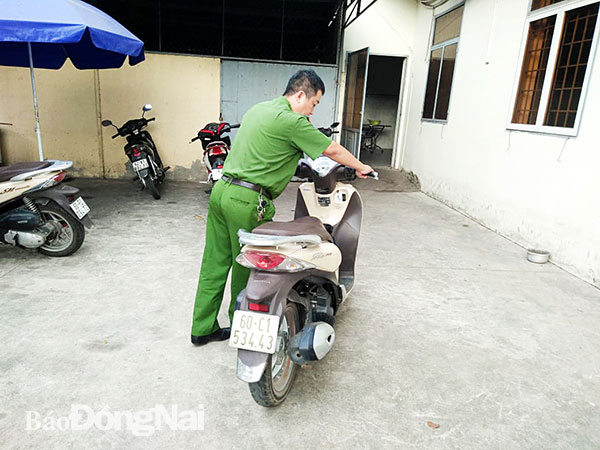

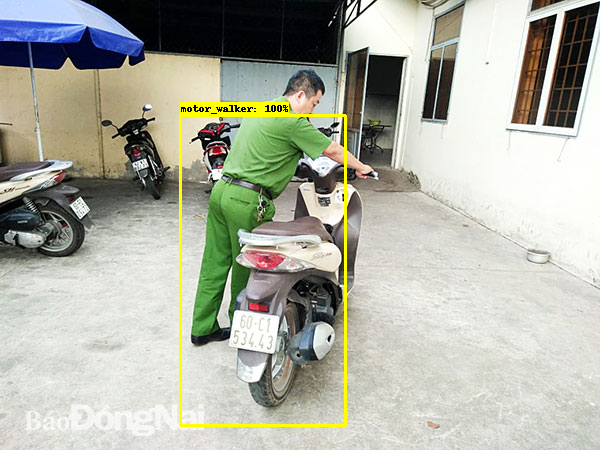

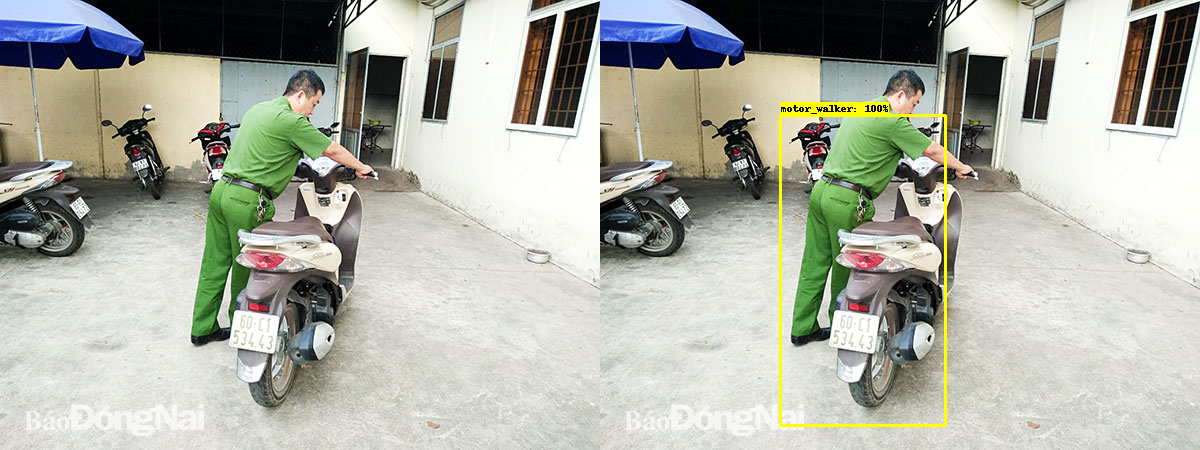

In [ ]:
#!pip install utils
import numpy as np
import os
import tensorflow as tf
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image

%cd /content/gdrive/My Drive/Classroom/VRA/walking/models/research
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

# path to the frozen graph:
PATH_TO_FROZEN_GRAPH = '/content/gdrive/My Drive/Classroom/VRA/walking/models/research/fine_tuned_model/frozen_inference_graph.pb'
#PATH_TO_FROZEN_GRAPH = '/content/gdrive/My Drive/Classroom/VRA/walking/Inference BK/SDD_frozen_inference_graph.pb'
# path to the label map
PATH_TO_LABEL_MAP = '/content/gdrive/My Drive/Classroom/VRA/walking/data/label_map.pbtxt'

# number of classes 
NUM_CLASSES = 2

#reads the frozen graph
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

label_map = label_map_util.load_labelmap(PATH_TO_LABEL_MAP)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

# Detection
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
          # Read image
          image = Image.open("/content/gdrive/My Drive/Classroom/VRA/walking/data/video/Input_pic_motor_walking.jpg")
          #image = Image.open("/content/gdrive/My Drive/Classroom/VRA/walking/data/video/Input_pic_bike_walking.jpg")
          frame = load_image_into_numpy_array(image)
          # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
          ##keep original ratio
          frame1 = frame
          frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)#new
          image_np_expanded = np.expand_dims(frame1, axis=0)
          # Extract image tensor
          image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
          # Extract detection boxes
          boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
          # Extract detection scores
          scores = detection_graph.get_tensor_by_name('detection_scores:0')
          # Extract detection classes
          classes = detection_graph.get_tensor_by_name('detection_classes:0')
          # Extract number of detections
          num_detections = detection_graph.get_tensor_by_name(
              'num_detections:0')
          # Actual detection.
          (boxes, scores, classes, num_detections) = sess.run(
              [boxes, scores, classes, num_detections],
              feed_dict={image_tensor: image_np_expanded}
          )

          # Visualization of the results of a detection.
          vis_util.visualize_boxes_and_labels_on_image_array(
            frame,
            np.squeeze(boxes),
            np.squeeze(classes).astype(np.int32),
            np.squeeze(scores),
            category_index,
            use_normalized_coordinates=True,
            line_thickness=3,
            min_score_thresh=0.60
          )
          
          # Display output
          cv2_imshow(cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB))
          cv2_imshow(frame)
          numpy_horizontal = np.hstack((cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB), frame))
          cv2_imshow(numpy_horizontal)

##Tensorboard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir '/content/gdrive/My Drive/Classroom/VRA/walking/models/research/training'

## LabelImg instruction

https://github.com/tzutalin/labelImg

1. Go to LabelImg folder
- cd C:\Users\Admin\Documents\Master UIT\Semester 6\Visual Recognition Application\labelImg-master

2. Run
- python labelImg.py

3. Hot key
- Ctrl + u Load all of the images from a directory
- Ctrl + r Change the default annotation target dir
- Ctrl + s Save
- Ctrl + d Copy the current label and rect box
- Ctrl + Shift + d Delete the current image
- Space Flag the current image as verified
- w Create a rect box
- d Next image
- a Previous image
- del Delete the selected rect box
- Ctrl++ Zoom in
- Ctrl-- Zoom out
- ↑→↓← | Keyboard arrows to move selected rect box

##Image resize

In [ ]:
import numpy as np
import cv2
import os
import math

%cd '/content/gdrive/My Drive/Classroom/VRA/Image_Resized'
dir_path = os.getcwd()

for filename in os.listdir(dir_path):
  # If the images are not .JPG images, change the line below to match the image type.
  if filename.endswith(".jpg"):
    #path & filename
    image = cv2.imread(filename)

    #get ratio of original size
    width_ori = image.shape[1] # keep original width 
    height_ori = image.shape[0] # keep original height 
    width = 450 
    height = math.ceil(width* height_ori/width_ori)
    dim = (width, height) # resize image 
    resized_hw = cv2.resize(image, dim, interpolation = cv2.INTER_AREA) 
    
    #proceed to resize
    cv2.imwrite(filename,resized_hw)